In [1]:
# 画像の読み込み
# $bash copy_image.sh　実行後のディレクトリ構成
# ref: https://qiita.com/ba--shi/items/09f5f2f119ffbd9bb316
import os
import cv2 # dockerの場合　$apt install libgl1-mesa-dev
import matplotlib.pyplot as plt

def modify_image(img, width, height):
    """指定した大きさに収まるように、アスペクト比を固定して、リサイズする。
       ref: https://camp.trainocate.co.jp/magazine/python-opencv/
    """
    h, w = img.shape[:2]
    aspect = w / h
    if width / height >= aspect:
        nh = height
        nw = round(nh * aspect)
    else:
        nw = width
        nh = round(nw / aspect)

    scaled = cv2.resize(img, dsize=(nw, nh))
    h_padding = round((height - nh) / 2)
    w_padding = round((width - nw) / 2)
    dst = cv2.copyMakeBorder(scaled, h_padding, height - nh - h_padding, w_padding, width- nw - w_padding, cv2.BORDER_REPLICATE)

    return dst

image_list = []
label_list = []
IMAGE_SIZE = 500
BASE_DIR = os.getcwd()

for dir in os.listdir(BASE_DIR + "/images"):
    img_dir =  BASE_DIR + "/images/" + dir
    # フォルダごとにラベル分けする
    label = dir
    
    for file in os.listdir(img_dir):
        # 配列label_listに正解ラベルを追加
        label_list.append(label)
        # 配列image_listに画像の配列データを追加
        filepath = img_dir + "/" + file
        img = cv2.imread(filepath)
        image = modify_image(img, IMAGE_SIZE, IMAGE_SIZE)
        # cv2.imwrite(f'modifyed/{file}', image)
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()
        # image = img_to_array(img)
        image_list.append(image)

In [2]:
import tensorflow as tf
import numpy as np

X = np.asarray(image_list).astype('float32') / 255.0

N_CLASSES = 15
Y = np.asarray(label_list)
Y = tf.keras.utils.to_categorical(Y, N_CLASSES)

print(X.shape, Y.shape)

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=0)

2023-10-15 01:50:52.814256: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-15 01:50:53.376311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-15 01:50:53.376348: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-15 01:50:53.379013: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-15 01:50:53.647024: I tensorflow/core/platform/cpu_feature_g

(314, 500, 500, 3) (314, 15)


In [3]:
callbacks = [
    # tf.keras.callbacks.EarlyStopping(
    #     patience=2, 
    #     restore_best_weights=True
    # ),
    # tf.keras.callbacks.ModelCheckpoint(
    #     '/code/road_sign/data/temp/road_sign_sequential_{epoch:03d}_{val_loss:.4f}.h5',
    #     save_best_only=True
    # ),
    # tf.keras.callbacks.TensorBoard(
    #     log_dir='/code/road_sign/logs',
    #     histogram_freq=1
    # ),
]

In [4]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import VGG16

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
for layer in vgg_model.layers:
    layer.trainable = False
    
x = vgg_model.output
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(N_CLASSES, activation='softmax')(x)

BATCH_SIZE = 32
EPOCHS = 10

model = tf.keras.Model(inputs=vgg_model.input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose='1', validation_data=(test_x, test_y), callbacks=callbacks)
model.save('model.h5')

2023-10-15 01:50:58.578248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 01:50:58.620290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 01:50:58.620342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 01:50:58.622957: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 01:50:58.622999: I tensorflow/compile

Epoch 1/10


2023-10-15 01:51:04.374069: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-10-15 01:51:07.254979: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.92GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-15 01:51:07.255027: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2023-10-15 01:51:10.346596: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were ava

Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<Axes: >

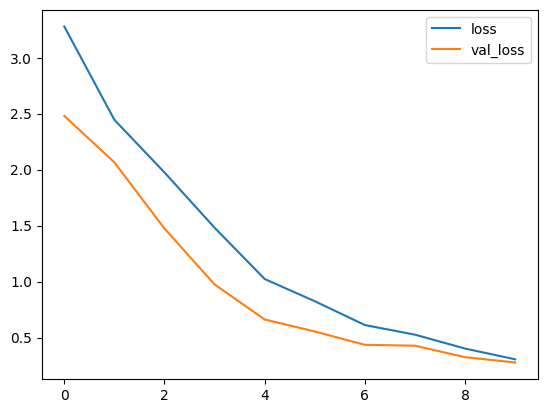

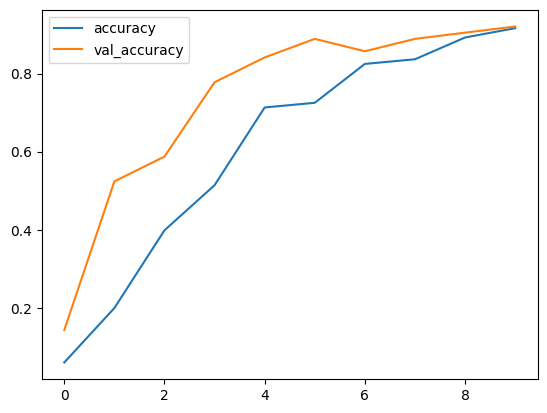

In [5]:
import pandas as pd

hist_df = pd.DataFrame(history.history)
hist_df[['loss', 'val_loss']].plot()
hist_df[['accuracy', 'val_accuracy']].plot()

In [6]:
score = model.evaluate(test_x, test_y, verbose='0')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.27781063318252563
Test accuracy: 0.920634925365448
